# Stock Trades by Members of the US House of Representatives


# Summary of Findings


### Introduction
In our project, we are attempting to predict whether a particular trade is a buy or sell, making this a classification problem. The target variable we will try and predict is 'type', which has three possibilities: purchase, sale_full, and sale_partial. We will be combining sale_full and sale_partial into one 'sale' value to make the column a binary type. We are hoping to get an R^2 score of .75 or higher on our model performances as that would let us know that our model works well.

### Baseline Model
The baseline model we used was the Decision Tree Classifier. It consists of three features which we one-hot encoded: ticker, and owner, and cap_gains_over_200_usd. both of which are nominal features. Our model performance came out to be around 62%, which was noticeably lower than our goal of 75% or higher. Although the score is not as high as we would have liked, we believe it is as high as we could get with the features and variables we had in this dataset. In addition, we do not consider 62% a bad score as our training accuracy was around 76%, which is not a huge difference from our test score.

### Final Model
We created some new features in addition to the stocks dataframe: transaction_month, disclosure_month, disclosure_diff, quarter_purchased. These features are mostly self explanatory, however the disclosure_diff column was made to show the number of days after the transaction was made was the transactiona actually disclosed. This allowed us to have more quantitative features available for us to use and combine when it came to getting a high accuracy test score. We ended up creating multiple models to compare testing scores which can be seen in the code below, but we went with the DecisionTreeClassifier model as it seemed to have scored the best. The RandomForestClassifier model had extremely similar test scores to the DecisionTree however, while the other models had significantly lower scores. By comparing multiple models' test scores, we came to the conclusion that the Decision Tree model was the best. Additionally, when picking paramaters, we used a manual iterative method by checking various different combinations of categorical and numerical features. We found that the parameters 'state', 'ticker', 'cap_gains_over_200_usd', 'owner', 'quarter_purchased', 'transaction_month', 'disclosure_month', and 'disclosure_diff' were used in multiple transformations in our final model. The transformers which gave us the best results were one-hot encoding the 'state', 'ticker', and 'cap_gains' columns, using the StdScalerByGroup() we implemented in lab 9 to standardize the 'quarter_purchased' column by the 'owner' type of the transaction, log-scaling the 'transaction_month' and 'disclosure_month', and imputing missing values of 'disclosure_diff' with the column's mean.

### Fairness Evaluation
For a fairness evaluation on this dataset, we can take a look at when exactly the transaction for the stock took place. One thing we can do is see whether or not the part of the year the transaction was made in affects the R^2 (or score) of the model we had built. For our permutation test, we can say that our null hypothesis is: the model is fair; the R^2 value for the two subsets are the same. For our alternative hypothesis, we can say the model is unfair; the R^2 value for the subset that included only the transactions made in the first half of the year is higher than that of the subset which shows purchases made in the second half of the year. To do this, we split up the dataset into two separate dataframes: one containing transactions made only in the first half of the year, the second containing transactions made only in the second half of the year. We then ran our best performing model, which used the DecisionTreeClassifier, on our newly separated dataframes, and calculated the R^2 of each model, and found the mean difference between the two scores over 500 trials. This ended up being 0.021926800323512106, which is not too high. We then ran the permutation test, again with 500 trials, but this time instead of splitting the dataset based on the time the transaction was made, we simply split the dataset randomly using train_test_split. From this, we again computed the R^2 of each model, and found the difference between the two scores. When comparing these scores to our observed values, we find a p-value of 0.328, and with a threshold of .05, we fail to reject our null hypothesis, and can conclude that the time of year in which the stock transaction was made is insignificant when training our model. 

# Code

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split



%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Data Cleaning

In [30]:
stocks = pd.read_csv('data/all_transactions.csv')

In [31]:
#new features to include in description - state, trans_month, disc_month, disc_diff, quarter_purchased
#replace blanks and dashes with NaN, drop link column for simplicity
def clean_helper(data):
    if data == '--':
        data = data.replace('--', 'NaN')
    if data == '':
        data = data.replace('', 'NaN')
    return data

def binarize_helper(data):
    if data == 'sale':
        data = 1
    if data == 'purchase':
        data = 0
    return data

def type_helper(data):
    if 'sale' in data:
        data = 'sale'
    return data
stocks = stocks.dropna()
stocks['owner'] = stocks['owner'].apply(clean_helper)
stocks['ticker'] = stocks['ticker'].apply(clean_helper)
stocks['type'] = stocks['type'].apply(type_helper)
stocks['type_binarized'] = stocks['type'].apply(binarize_helper)
stocks = stocks.drop(columns = ['ptr_link'])
#convert disclosure and transaction date to datetime, 
#create new column calculating the time from transaction date and to datetime
stocks['disclosure_date'] = pd.to_datetime(stocks['disclosure_date'], exact=False, errors='coerce')
stocks['transaction_date'] = pd.to_datetime(stocks['transaction_date'], exact=False, errors='coerce')
stocks['disclosure_diff'] = stocks['disclosure_date'] - stocks['transaction_date']
stocks['disclosure_diff'] = stocks['disclosure_diff'].dt.days
stocks = stocks.dropna()
stocks['disclosure_diff'] = stocks['disclosure_diff'].astype(int)
#create new column showing the state from which the representative who purchased the stock is from
stocks['state'] = stocks['district'].astype(str).str[:-2]

### Baseline Model

In [32]:
def baseline_model(data):
    copy = data.copy()
    cat_feat = ['ticker', 'owner', 'cap_gains_over_200_usd']
    preproc = ColumnTransformer(
        transformers = [
            ('one-hot', OneHotEncoder(handle_unknown = 'ignore'), cat_feat)
        ])
    pl = Pipeline(steps = [('preprocessor', preproc), ('dtc', DecisionTreeClassifier())])
    X = copy.drop('type', axis = 1)
    y = copy.type
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pl.fit(X_train, y_train)
    score = pl.score(X_test, y_test)
    return score

0.6269191402251791

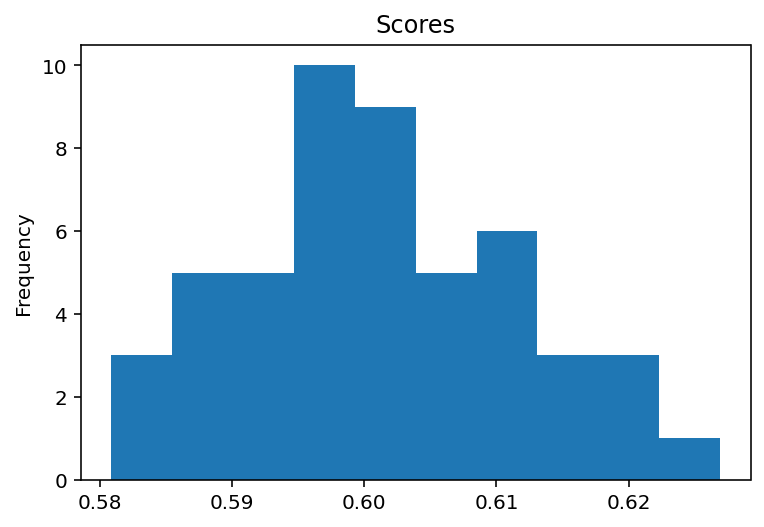

In [33]:
scores = []
for i in range(50):
    score = baseline_model(stocks)
    scores.append(score)
pd.Series(scores).plot(kind = 'hist', title = 'Scores')
max(scores)

### Final Model

In [34]:
stocks['transaction_date'] = pd.DatetimeIndex(stocks['transaction_date']).month
stocks = stocks.rename(columns = {'transaction_date': 'transaction_month'})


stocks['disclosure_date'] = pd.DatetimeIndex(stocks['disclosure_date']).month
stocks = stocks.rename(columns = {'disclosure_date': 'disclosure_month'})

In [35]:
def month_bin(month):
    if month >= 1 and month <= 3:
        month = 1
    if month >= 4 and month <= 6:
        month = 2
    if month >= 7 and month <= 9:
        month = 3
    if month >= 10 and month <= 12:
        month = 4
    return month

stocks['quarter_purchased'] = stocks['transaction_month'].apply(month_bin)

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin


class StdScalerByGroup(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 2, 2], 'c2': [3, 1, 2, 0]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> std.grps_ is not None
        True
        """
        # X may not be a pandas dataframe (e.g. a np.array)
        df = pd.DataFrame(X)
        # A dictionary of means/standard-deviations for each column, for each group.
        mean = df.groupby(df.columns[0]).mean().to_dict()
        std = df.groupby(df.columns[0]).std().to_dict()
        self.grps_ = (mean, std)
        return self

    def transform(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 3, 4], 'c2': [1, 2, 3, 4]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> out = std.transform(X)
        >>> out.shape == (4, 2)
        True
        >>> np.isclose(out.abs(), 0.707107, atol=0.001).all().all()
        True
        """
        #- z-score: z = (x-μ)/σ, where x is the raw score, μ is the population mean, and σ is the population standard deviation.

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")
        
        # Define a helper function here?
        def find_z_score(group, column, raw_score):
            #try:
                mean = self.grps_[0][column][group]
                std = self.grps_[1][column][group]
                z_score = (raw_score - mean) / std
                return z_score
            #except KeyError:
                #return 0
        #X may not be a dataframe (e.g. np.array)
        df = pd.DataFrame(X)
        copy = df.copy()
        copy = copy.iloc[: , 1:]
        group = df.iloc[:, 0]
        result = copy.copy()
        for i in group.unique():
            for j in copy:
                raw_score = df[[j]]
                raw_score = raw_score.loc[group == i].astype(float)
                result.update(find_z_score(i, j, raw_score))
        return result

In [37]:
def DTC_model(data):
    copy = data.copy()
    preproc = ColumnTransformer(
        transformers = [
            ('one-hot', OneHotEncoder(handle_unknown = 'ignore'), ['state', 'ticker', 'cap_gains_over_200_usd']),
            ('std-scaler', StdScalerByGroup(), ['owner', 'quarter_purchased']),
            ('log', FunctionTransformer(np.log1p, validate = True), ['transaction_month', 'disclosure_month']),
            ('impute', SimpleImputer(missing_values = np.nan, strategy = 'mean'), ['disclosure_diff'])
        ])
    pl = Pipeline(steps = [('preprocessor', preproc), ('dtc', DecisionTreeClassifier())])
    X = copy.drop('type', axis = 1)
    y = copy.type
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pl.fit(X_train, y_train)
    preds = pl.predict(X_test)
    score = pl.score(X_test, y_test)
    return score

0.7645854657113613

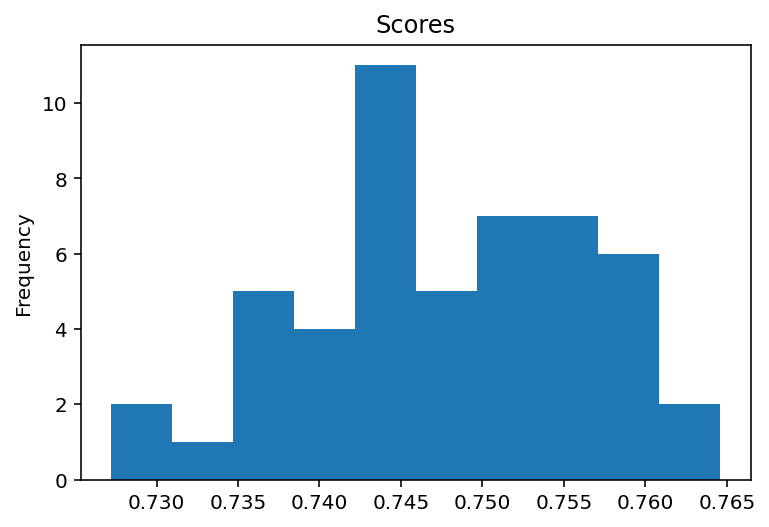

In [39]:
stocks = stocks.dropna()
scores = []
for i in range(50):
    score = DTC_model(stocks)
    scores.append(score)
pd.Series(scores).plot(kind = 'hist', title = 'Scores')
max(scores)

In [40]:
def KNC_model(data):
    copy = data.copy()
    preproc = ColumnTransformer(
        transformers = [
            ('one-hot', OneHotEncoder(handle_unknown = 'ignore'), ['state', 'ticker', 'cap_gains_over_200_usd']),
            ('std-scaler', StdScalerByGroup(), ['owner', 'quarter_purchased']),
            ('log', FunctionTransformer(np.log1p, validate = True), ['transaction_month', 'disclosure_month']),
            ('impute', SimpleImputer(missing_values = np.nan, strategy = 'mean'), ['disclosure_diff'])
        ])
    pl = Pipeline(steps = [('preprocessor', preproc), ('dtc', KNeighborsClassifier())])
    X = copy.drop('type', axis = 1)
    y = copy.type
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pl.fit(X_train, y_train)
    preds = pl.predict(X_test)
    score = pl.score(X_test, y_test)
    return score

0.710849539406346

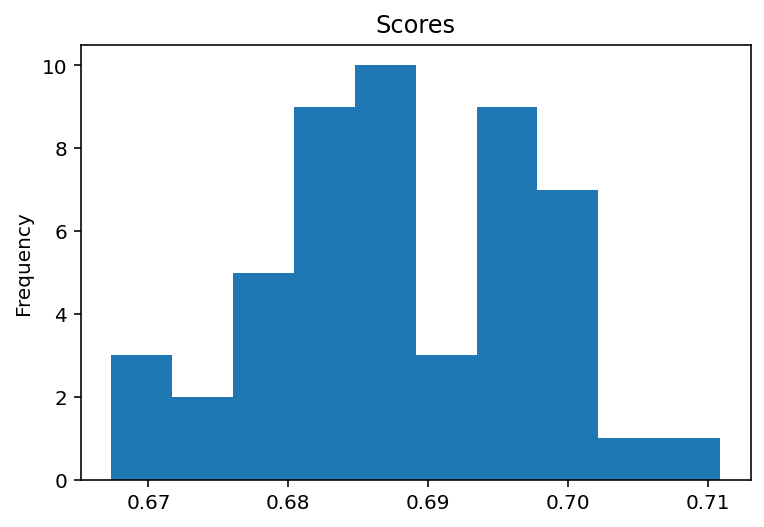

In [41]:
stocks = stocks.dropna()
scores = []
for i in range(50):
    score = KNC_model(stocks)
    scores.append(score)
pd.Series(scores).plot(kind = 'hist', title = 'Scores')
max(scores)

In [42]:
def random_forest_model(data):
    copy = data.copy()
    preproc = ColumnTransformer(
        transformers = [
            ('one-hot', OneHotEncoder(handle_unknown = 'ignore'), ['state', 'ticker', 'cap_gains_over_200_usd']),
            ('std-scaler', StdScalerByGroup(), ['owner', 'quarter_purchased']),
            ('log', FunctionTransformer(np.log1p, validate = True), ['transaction_month', 'disclosure_month']),
            ('impute', SimpleImputer(missing_values = np.nan, strategy = 'mean'), ['disclosure_diff'])
        ])
    pl = Pipeline(steps = [('preprocessor', preproc), ('dtc', RandomForestClassifier())])
    X = copy.drop('type', axis = 1)
    y = copy.type
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pl.fit(X_train, y_train)
    preds = pl.predict(X_test)
    score = pl.score(X_test, y_test)
    return score

0.7804503582395087

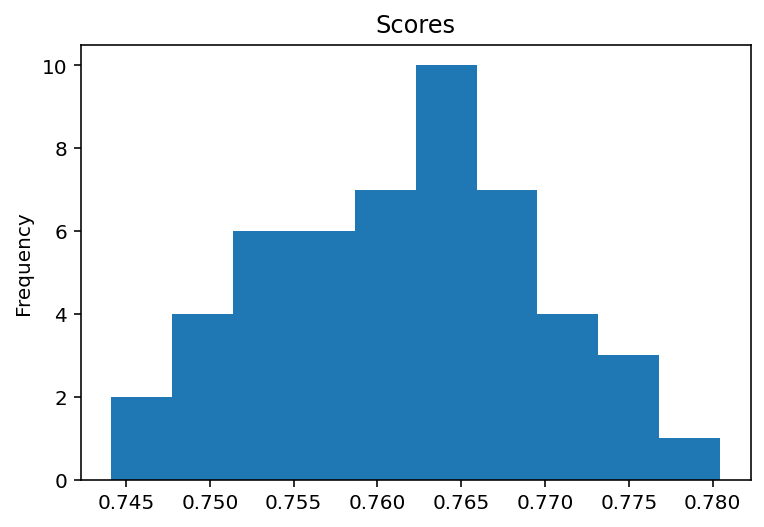

In [43]:
stocks = stocks.dropna()
scores = []
for i in range(50):
    score = random_forest_model(stocks)
    scores.append(score)
pd.Series(scores).plot(kind = 'hist', title = 'Scores')
max(scores)

In [44]:
def SVC_model(data):
    copy = data.copy()
    preproc = ColumnTransformer(
        transformers = [
            ('one-hot', OneHotEncoder(handle_unknown = 'ignore'), ['state', 'ticker', 'cap_gains_over_200_usd']),
            ('std-scaler', StdScalerByGroup(), ['owner', 'quarter_purchased']),
            ('log', FunctionTransformer(np.log1p, validate = True), ['transaction_month', 'disclosure_month']),
            ('impute', SimpleImputer(missing_values = np.nan, strategy = 'mean'), ['disclosure_diff'])
        ])
    pl = Pipeline(steps = [('preprocessor', preproc), ('dtc', SVC())])
    X = copy.drop('type', axis = 1)
    y = copy.type
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pl.fit(X_train, y_train)
    preds = pl.predict(X_test)
    score = pl.score(X_test, y_test)
    return score

0.5813715455475946

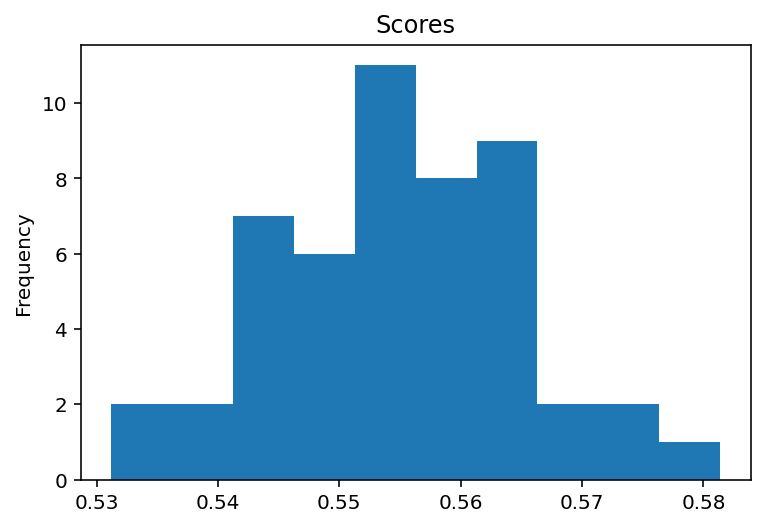

In [45]:
stocks = stocks.dropna()
scores = []
for i in range(50):
    score = SVC_model(stocks)
    scores.append(score)
pd.Series(scores).plot(kind = 'hist', title = 'Scores')
max(scores)

### Fairness Evaluation

In [109]:
def get_obs(data, N):
    copy = data.copy()
    first_half = copy[copy['transaction_month'] <= 6]
    second_half = copy[copy['transaction_month'] >= 7]
    r2_diff = []
    
    for i in range(N):
        preproc = ColumnTransformer(
        transformers = [
            ('one-hot', OneHotEncoder(handle_unknown = 'ignore'), ['state', 'ticker', 'cap_gains_over_200_usd']),
            ('std-scaler', StdScalerByGroup(), ['owner', 'quarter_purchased']),
            ('log', FunctionTransformer(np.log1p, validate = True), ['transaction_month', 'disclosure_month']),
            ('impute', SimpleImputer(missing_values = np.nan, strategy = 'mean'), ['disclosure_diff'])
        ])
        
        
        pl1 = Pipeline(steps = [('preprocessor', preproc), ('dtc', DecisionTreeClassifier())])
        X1 = first_half.drop('type', axis = 1)
        y1 = first_half.type
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1)
        pl1.fit(X_train1, y_train1)
        score1 = pl1.score(X_test1, y_test1)
        
        pl2 = Pipeline(steps = [('preprocessor', preproc), ('dtc', DecisionTreeClassifier())])
        X2 = second_half.drop('type', axis = 1)
        y2 = second_half.type
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2)
        pl2.fit(X_train2, y_train2)
        score2 = pl2.score(X_test2, y_test2)
        
        r2_diff.append(abs(score1 - score2))
    return r2_diff

In [110]:
stocks = stocks.dropna()
obs = np.mean(get_obs(stocks, 500))
obs

0.021926800323512106

In [111]:
def perm_test(data, N):
    copy = data.copy()
    r2_diff = []
    test_dfA, test_dfB = train_test_split(copy, test_size = 0.5)

    for i in range(N):
        preproc = ColumnTransformer(
        transformers = [
            ('one-hot', OneHotEncoder(handle_unknown = 'ignore'), ['state', 'ticker', 'cap_gains_over_200_usd']),
            ('std-scaler', StdScalerByGroup(), ['owner', 'quarter_purchased']),
            ('log', FunctionTransformer(np.log1p, validate = True), ['transaction_month', 'disclosure_month']),
            ('impute', SimpleImputer(missing_values = np.nan, strategy = 'mean'), ['disclosure_diff'])
        ])
        
        
        pl1 = Pipeline(steps = [('preprocessor', preproc), ('dtc', DecisionTreeClassifier())])
        X1 = test_dfA.drop('type', axis = 1)
        y1 = test_dfA.type
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1)
        pl1.fit(X_train1, y_train1)
        score1 = pl1.score(X_test1, y_test1)
        
        pl2 = Pipeline(steps = [('preprocessor', preproc), ('dtc', DecisionTreeClassifier())])
        X2 = test_dfB.drop('type', axis = 1)
        y2 = test_dfB.type
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2)
        pl2.fit(X_train2, y_train2)
        score2 = pl2.score(X_test2, y_test2)
        
        r2_diff.append(score1 - score2)
    return r2_diff

In [112]:
stocks = stocks.dropna()
N = 500
differences = perm_test(stocks, N)
p_value = np.mean(differences > obs)
p_value

0.328